In [1]:
# imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#from prettytable import PrettyTable
import random
import os
from datetime import datetime
from torch.optim import lr_scheduler
import pandas as pd
from skimage import exposure

# local imports
from models_parameters import losses
from utils import helper_functions
from utils.dataloader import Dataset as dataset
from utils.losses import calculate_metrics
import geopandas
from utils.convert import convert_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\accou\anaconda3\envs\geo_env_n6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
#srcnn_checkpoint = "model_files/srcnn_x4.pth"
#rcan_checkpoint  = "model_files/rcan_4x.pt"
#srgan_checkpoint = "model_files/srgan_4x.pth.tar"
#srgan_temporal_checkpoint = "model_files/srgan_4x_temporal.tar"
srgan_fusion_checkpoint = "model_files/fusion_model_weights.pth"

In [3]:
def load_dataloader(dl_type="normal",sen2_test_tile="all"):
    
    working_directory = "C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\"
    folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
    dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"
    
    #filter_point=(367500.0,6822750.0) # Good one
    #filter_point=(292500.0,6810750.0) # BEST
    filter_point = (240750.0 , 6840000.0)
    filter_point = "None"

    
    if dl_type == "normal":
        from utils.dataloader import Dataset as dataset
        dataset_test   = dataset(folder_path,dataset_file,test_train_val="test",transform="histogram_matching",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
        loader_test = DataLoader(dataset_test,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)
    if dl_type == "srcnn":
        from utils.dataloader_srcnn import Dataset as dataset
        dataset_test   = dataset(folder_path,dataset_file,test_train_val="test",transform="interpolate",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
        loader_test = DataLoader(dataset_test,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)
    if dl_type == "temporal":
        from utils.dataloader_temporal import Dataset as dataset
        dataset_test   = dataset(folder_path,dataset_file,test_train_val="test",transform=None,sen2_amount=4, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
        loader_test = DataLoader(dataset_test,batch_size=2, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)
    return loader_test

In [4]:
def load_SRCNN(checkpoint):
    from torch import nn
    class SRCNN(nn.Module):
        def __init__(self, num_channels=1):
            super(SRCNN, self).__init__()
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
            self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
            self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
            self.relu = nn.ReLU(inplace=True)

        def forward(self, x):
            x = self.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            x = self.conv3(x)
            return x
    model = SRCNN()
    model.load_state_dict(torch.load(checkpoint))
    #model = torch.load(checkpoint)
    model = model.to(device)
    model = model.eval()
    return model

def load_RCAN(checkpoint):
    model = torch.load(checkpoint)
    model = model.to(device)
    model = model.eval()
    return model

def load_SRGAN(checkpoint):
    model = torch.load(checkpoint)["generator"]
    model = model.to(device)
    model = model.eval()
    return(model)

def load_SRGAN_fusion(checkpoint):
    from models import Generator
    # Generator parameters
    large_kernel_size_g = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
    small_kernel_size_g = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
    n_channels_g = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
    n_blocks_g = 16  # number of residual blocks
    scaling_factor = 4
    generator = Generator(large_kernel_size=large_kernel_size_g,
                                  small_kernel_size=small_kernel_size_g,
                                  n_channels=n_channels_g,
                                  n_blocks=n_blocks_g,
                                  scaling_factor=scaling_factor)

    #generator = torch.load(checkpoint)["generator"]
    generator.load_state_dict(torch.load(checkpoint))
    generator = generator.to(device)
    generator = generator.eval()
    return(generator)


In [5]:
def sr_srcnn(img):
    model = model_SRCNN
    img = img[0]
    #img = img.numpy()
    ls = []
    for i in img:
        ls.append(model(i.unsqueeze(0))[0])
    r = torch.stack(ls)
    return(r.unsqueeze(0))

In [6]:
#model_SRCNN = load_SRCNN(srcnn_checkpoint)
#model_RCAN  = load_RCAN(rcan_checkpoint)
#model_SRGAN = load_SRGAN(srgan_checkpoint)
#model_SRGAN_temporal = load_SRGAN(srgan_temporal_checkpoint)
model_SRGAN_fusion = load_SRGAN_fusion(srgan_fusion_checkpoint)

In [7]:
#loader_SRCNN = load_dataloader("srcnn")
#loader_RCAN = load_dataloader("normal")
#loader_SRGAN = load_dataloader("normal")
loader_SRGAN_temporal = load_dataloader("temporal")

In [8]:
len(loader_SRGAN_temporal)

8826

In [9]:
def test_model(model,dataloader):
    def avg_ls(list):
        return sum(lst) / len(lst)
    
    ls = []
    metrics_list = []
    count = 0
    for lr,hr,coor in dataloader:
        count=count+1
        lr,hr = lr.to(device),hr.to(device)
        model = model.to(device)
        sr = model(lr)
        if lr.shape == torch.Size([2, 12, 75, 75]):
            sr = sr[0].unsqueeze(0)
            hr = hr[0].unsqueeze(0)
            lr = lr[:,:3,::]
            coor = coor[0]
        metrics = calculate_metrics(hr,lr,sr)
        # order: [lpips,psnr,ssim,mae,lpips_int,psnr_int,ssim_int,mae_int]
        metrics_list.append(metrics)    
        ls.append([coor[0].item(),coor[1].item(),metrics[0]])
       
    
    df = pd.DataFrame(metrics_list,columns=["lpips","psnr","ssim","mae","lpips_int","psnr_int","ssim_int","mae_int"])
    df = df.mean(axis=0).to_frame().transpose()
    
    print("one run finished")
    global res
    res = ls
    return df

In [10]:
df = pd.concat([test_model(model_SRGAN_fusion,loader_SRGAN_temporal)])

FATAL ERROR IN DATALOADER: 1st loaded Sen2 image has invalid shape, initializing random instead! Following Images are likely still valid.
warning, invalid sen2 shape. repeaeted first sen2 acquisition is concatenated instead
warning, invalid sen2 shape. repeaeted first sen2 acquisition is concatenated instead
FATAL ERROR IN DATALOADER: 1st loaded Sen2 image has invalid shape, initializing random instead! Following Images are likely still valid.
warning, invalid sen2 shape. repeaeted first sen2 acquisition is concatenated instead
FATAL ERROR IN DATALOADER: 1st loaded Sen2 image has invalid shape, initializing random instead! Following Images are likely still valid.
warning, invalid sen2 shape. repeaeted first sen2 acquisition is concatenated instead
FATAL ERROR IN DATALOADER: 1st loaded Sen2 image has invalid shape, initializing random instead! Following Images are likely still valid.
warning, invalid sen2 shape. repeaeted first sen2 acquisition is concatenated instead
FATAL ERROR IN DAT

In [11]:
df

,lpips,psnr,ssim,mae,lpips_int,psnr_int,ssim_int,mae_int
0,0.397176,16.418471,0.48146,0.137556,0.331989,inf,0.080912,0.016151


# Produce Prediction Images

In [12]:
from utils.helper_functions import plot_tensors_window
from utils.helper_functions import count_parameters
import itertools
from prettytable import PrettyTable

In [13]:
#model_SRCNN = load_SRCNN(srcnn_checkpoint)
#model_RCAN  = load_RCAN(rcan_checkpoint)
#model_SRGAN = load_SRGAN(srgan_checkpoint)
#model_SRGAN_temporal = load_SRGAN(srgan_temporal_checkpoint)
model_SRGAN_fusion = load_SRGAN_fusion(srgan_fusion_checkpoint)

In [14]:
#loader_SRCNN = load_dataloader("srcnn")
#loader_RCAN = load_dataloader("normal")
#loader_SRGAN = load_dataloader("normal")
loader_SRGAN_temporal = load_dataloader("temporal")

In [15]:
def produce_images(model,loader,image_folder):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    def avg_ls(list):
        return sum(lst) / len(lst)
    
    
    lr,hr,coor = next(itertools.islice(loader, 0, None)) # good: 250
    
    
    ls = []
    metrics_list = []
    count = 0
    
    count=count+1
    lr,hr = lr.to(device),hr.to(device)
    sr = model(lr)
    sr = sr.to(device)
    sr = convert_image(sr, source='[-1, 1]', target='imagenet-norm')
    sr = sr[0].unsqueeze(0)
    hr = hr[0].unsqueeze(0)
    coor = coor[0].unsqueeze(0)
    metrics = calculate_metrics(hr,lr,sr) # [:,:3,:,:]
    # order: [lpips,psnr,ssim,mae,lpips_int,psnr_int,ssim_int,mae_int]
    metrics_list.append(metrics)    
    ls.append([coor[0][0].item(),coor[0][1].item(),metrics[0]])
        
    
    if lr.shape!= torch.Size([1, 3, 300, 300]):
        plot_tensors_window(hr,lr[:,:3,::],sr,fig_path=image_folder+"/")
    else:
        plot_tensors_window(hr,lr,sr,fig_path=image_folder+"/")
        
    #try:
    #    count_parameters(model)
    #except:
    #    count_parameters(model_SRCNN)
    
    df = pd.DataFrame(metrics_list,columns=["lpips","psnr","ssim","mae","lpips_int","psnr_int","ssim_int","mae_int"])
    df = df.mean(axis=0).to_frame().transpose()
    
    res = ls
    #return df


SRGAN fusion
cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


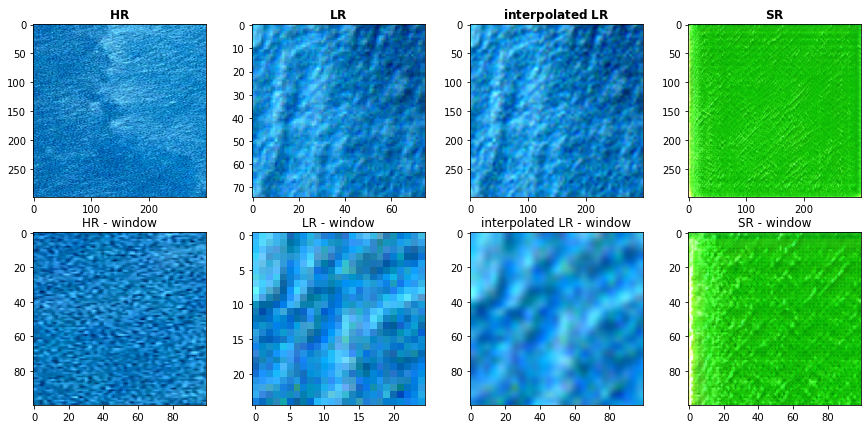

In [16]:
#print("SRCNN")
#produce_images(sr_srcnn,loader_SRCNN,"images_pred/SRCNN")
#print("\nRCAN")
#produce_images(model_RCAN,loader_RCAN,"images_pred/RCAN")
#print("\nSRGAN")
#produce_images(model_SRGAN,loader_SRGAN,"images_pred/SRGAN")
#print("\nSRGAN band stacking")
#produce_images(model_SRGAN_temporal,loader_SRGAN_temporal,"images_pred/SRGAN_batch")
print("\nSRGAN fusion")
produce_images(model_SRGAN_fusion,loader_SRGAN_temporal,"images_pred/SRGAN_fusion")